### Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Database

In [2]:
data = pd.DataFrame({
    "Name":['C1', 'C2', 'C3', 'NC4', 'NC5', 'C6', 'C7+'],
    "Crit Pres (Psia)":[666.40, 706.50, 616.00, 527.90, 488.60, 453.00, 285.00],
    "Crit Temp (R)":[343.33, 549.92, 666.06, 765.62, 845.80, 923.00, 700.00+460],
    "Acentric Factor":[0.01, 0.10, 0.15, 0.19, 0.23, 0.25, 0.5721],
    "Mol Weight":[16.043, 30.07, 44.097, 58.123, 72.15, 84, 240]
})

### Define Components

In [3]:
name = ['C1', 'C2', 'C3', 'NC4', 'NC5', 'C6', 'C7+']
comp = [0.7, 0.05, 0.05, 0.04, 0.04, 0.02, 0.1]

### Get Properties From Database

In [4]:
mw = []
pc = []
tc = []
om = []
for i in range (len(name)):
    mw.append(data[data['Name'] == name[i]]['Mol Weight'].values[0])
    pc.append(data[data['Name'] == name[i]]['Crit Pres (Psia)'].values[0])
    tc.append(data[data['Name'] == name[i]]['Crit Temp (R)'].values[0])
    om.append(data[data['Name'] == name[i]]['Acentric Factor'].values[0])

### Define Pressure and Temperature

In [5]:
pres = [i for i in range (2100, 2150, 50)]
temp = 110 + 460
r = 10.732

### Calculate Z-Factor By PR EOS

In [6]:
kappa = [0.37464 + 1.54226*i - 0.26992*(i**2) for i in om]
alpha = [(1+kappa[i]*(1-np.sqrt(temp/tc[i])))**2 for i in range (len(kappa))]
ac = [0.45724*((r*tc[i])**2)/pc[i] for i in range (len(name))]
b = [0.07780*r*tc[i]/pc[i] for i in range (len(name))]
aap_mix = 0
b_mix = 0
for i in range (len(name)):
    for j in range (len(name)):
        aap_mix += comp[i]*comp[j]*np.sqrt(ac[i]*ac[j]*alpha[i]*alpha[j])
    b_mix += comp[i]*b[i]
z_fact = []
for p in pres:
    a_val = aap_mix*p/((r*temp)**2)
    b_val = b_mix*p/(r*temp)
    coef = [1, -1+b_val, (a_val-3*(b_val**2) - 2*b_val), - (a_val*b_val - b_val**2 - b_val**3)]
    roots = np.roots(coef)
    z_fact.append(np.max(roots.real))

In [7]:
mw_mix = 0
for i in range (len(name)):
    mw_mix += comp[i]*mw[i]
sg = mw_mix/28.97
pc_mix = 709.604 - 58.718*sg
tc_mix = 170.491 + 307.344*sg

### Calculations of Other Properties

In [8]:
bgi = [0.0283*z_fact[i]*temp/pres[i] for i in range (len(pres))]
rhog = [2.7*sg*pres[i]/(z_fact[i]*temp) for i in range (len(pres))]
visg = []
for i in range (len(pres)):
    a_const = (9.379+0.01607*mw_mix)*(temp**1.5)/(209.2+19.26*mw_mix+temp)
    b_const = 3.448 + 986.4/temp + 0.01009*mw_mix
    c_const = 2.447 - 0.2224*b_const
    visg.append(a_const*np.exp(b_const*((rhog[i]/62.428)**c_const))/1e4)

In [9]:
bg_value = bgi[0]

### Function for Get Data Distribution

In [10]:
def getTriangularDist(minimum, maximum, mean, n=1000000):
    wmean = ((mean-minimum)**2)/((maximum-minimum)*(mean-minimum))
    array = []
    for i in range (n):
        randnum = np.random.random()
        if (randnum > wmean):
            array.append(maximum - ((1 - randnum)*(maximum - minimum)*(maximum - mean))**0.5)
        else:
            array.append(minimum + ((randnum)*(maximum - minimum)*(mean - minimum))**0.5)
    return array

In [11]:
def getNormalDist(mean, std, n=1000000):
    array = []
    for i in range (n):
        array.append(np.random.normal(loc=mean, scale=std))
    return array

In [12]:
def getUniformDist(minimum, maximum, n=1000000):
    array = []
    for i in range (n):
        array.append(minimum + np.random.random()*(maximum-minimum))
    return array

### Create Area Distribution

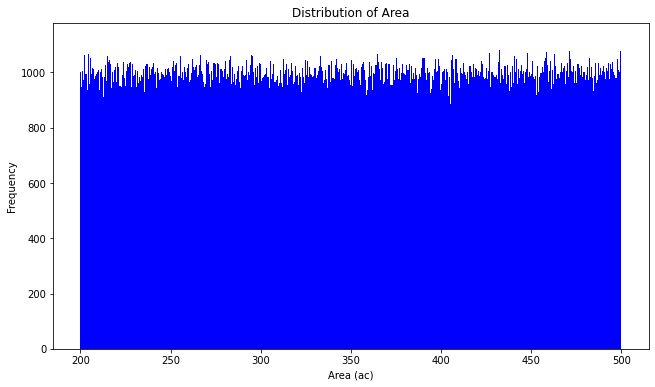

In [13]:
areadist = getUniformDist(minimum=200, maximum=500)
plt.figure(figsize=(16/1.5,9/1.5))
plt.hist(areadist, bins=1000, color='blue')
plt.xlabel("Area (ac)")
plt.ylabel("Frequency")
plt.title("Distribution of Area")
plt.show()

### Create Thickness Distribution

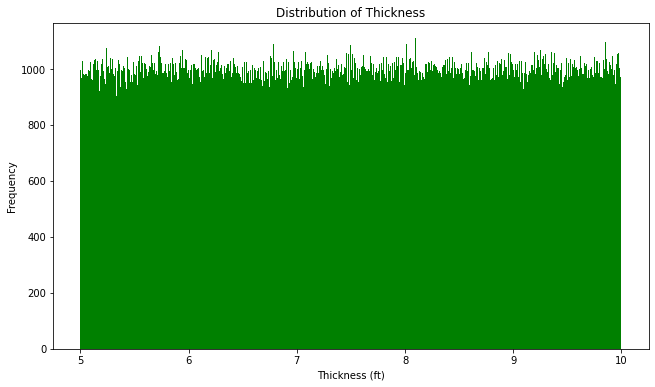

In [14]:
thicknessdist = getUniformDist(minimum=5, maximum=10)
plt.figure(figsize=(16/1.5,9/1.5))
plt.hist(thicknessdist, bins=1000, color='green')
plt.xlabel("Thickness (ft)")
plt.ylabel("Frequency")
plt.title("Distribution of Thickness")
plt.show()

### Create Porosity Distribution

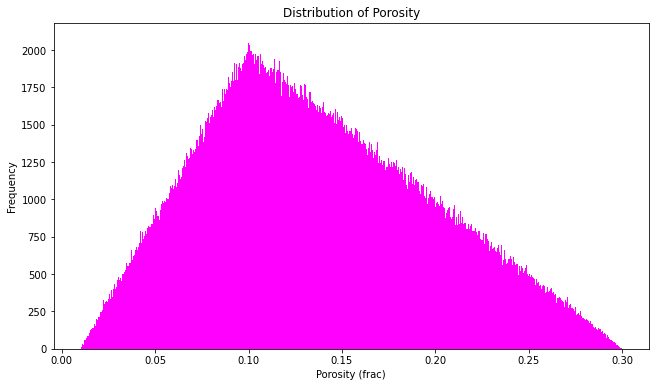

In [15]:
pordist = getTriangularDist(minimum=0.01, maximum=0.3, mean=0.1)
plt.figure(figsize=(16/1.5,9/1.5))
plt.hist(pordist, bins=1000, color='magenta')
plt.xlabel("Porosity (frac)")
plt.ylabel("Frequency")
plt.title("Distribution of Porosity")
plt.show()

### Create Water Saturation Distribution

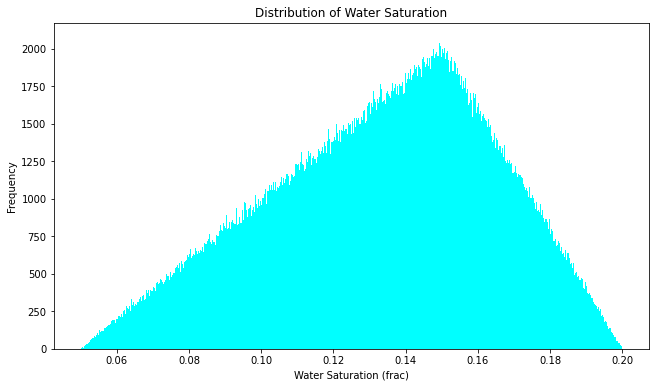

In [16]:
swdist = getTriangularDist(minimum=0.05, maximum=0.2, mean=0.15)
plt.figure(figsize=(16/1.5,9/1.5))
plt.hist(swdist, bins=1000, color='cyan')
plt.xlabel("Water Saturation (frac)")
plt.ylabel("Frequency")
plt.title("Distribution of Water Saturation")
plt.show()

### Create Gas FVF Distribution

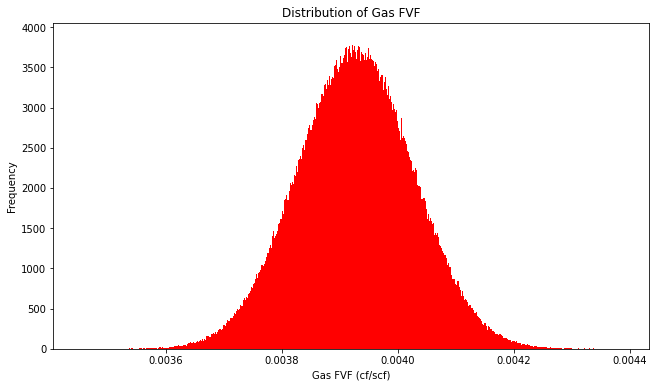

In [17]:
bgdist = getNormalDist(mean=bg_value, std=0.0001)
plt.figure(figsize=(16/1.5,9/1.5))
plt.hist(bgdist, bins=1000, color='red')
plt.xlabel("Gas FVF (cf/scf)")
plt.ylabel("Frequency")
plt.title("Distribution of Gas FVF")
plt.show()

### Calculate IGIP Distribution

In [18]:
vgi = [43560*areadist[i]*thicknessdist[i]*pordist[i]*(1-swdist[i])/bgdist[i]/1000000000 for i in range (len(areadist))]

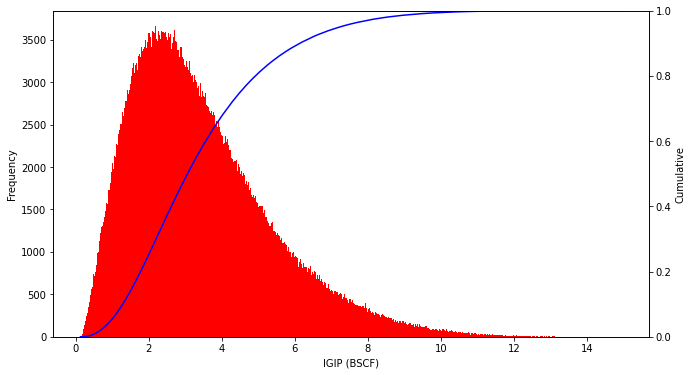

In [19]:
values, base = np.histogram(vgi, bins=1000)
cumulative = np.cumsum(values)
fig, ax = plt.subplots(figsize=(16/1.5,9/1.5))
ax1 = ax.twinx()
ax.hist(vgi, bins=1000, color='red')
ax1.plot(base[:-1], cumulative/max(cumulative), color='blue')
ax1.set_ylim(0,1)
ax1.set_ylabel("Cumulative")
ax.set_ylabel("Frequency")
ax.set_xlabel("IGIP (BSCF)")
plt.show()

### Value of P-10, P-50, and P-90

In [20]:
print("Value of P-10 : ", round(np.percentile(vgi, 90), 4), " BSCF")
print("Value of P-50 : ", round(np.percentile(vgi, 50), 4), " BSCF")
print("Value of P-90 : ", round(np.percentile(vgi, 10), 4), " BSCF")

Value of P-10 :  6.1538  BSCF
Value of P-50 :  3.073  BSCF
Value of P-90 :  1.2982  BSCF
